In [0]:
USE_COLAB = True

In [2]:
# in google colab uncomment this
if USE_COLAB:
  import os

  os.system('apt-get install -y xvfb')
  os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')

  prefix = 'https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week06_policy_based/'

  os.system('wget ' + prefix + 'atari_wrappers.py')
  os.system('wget ' + prefix + 'env_batch.py')
  os.system('wget ' + prefix + 'runners.py')

  os.system('apt-get install -y python-opengl ffmpeg')
  os.system('pip install pyglet==1.2.4')

  os.system('python -m pip install -U pygame --user')

  print('setup complete')

  # # XVFB will be launched if you run on a server
  # if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
  #     !bash ../xvfb start
  #     os.environ['DISPLAY'] = ':1'

setup complete


# Implementing Advantage-Actor Critic (A2C)

In this notebook you will implement Advantage Actor Critic algorithm that trains on a batch of Atari 2600 environments running in parallel. 

Firstly, we will use environment wrappers implemented in file `atari_wrappers.py`. These wrappers preprocess observations (resize, grayscal, take max between frames, skip frames and stack them together) and rewards. Some of the wrappers help to reset the environment and pass `done` flag equal to `True` when agent dies.
File `env_batch.py` includes implementation of `ParallelEnvBatch` class that allows to run multiple environments in parallel. To create an environment we can use `nature_dqn_env` function. Note that if you are using 
PyTorch and not using `tensorboardX` you will need to implement a wrapper that will log **raw** total rewards that the *unwrapped* environment returns and redefine the implemention of `nature_dqn_env` function here. 



In [3]:
if USE_COLAB:
    %tensorflow_version 1.x
import numpy as np
import math
import torch
import torch.nn as nn
from atari_wrappers import nature_dqn_env
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm import trange
from pandas import DataFrame

test_env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=8)
test_obs = test_env.reset()
assert test_obs.shape == (8, 84, 84, 4)
assert test_obs.dtype == np.uint8

TensorFlow 1.x selected.



Next, we will need to implement a model that predicts logits and values. It is suggested that you use the same model as in [Nature DQN paper](https://web.stanford.edu/class/psych209/Readings/MnihEtAlHassibis15NatureControlDeepRL.pdf) with a modification that instead of having a single output layer, it will have two output layers taking as input the output of the last hidden layer. **Note** that this model is different from the model you used in homework where you implemented DQN. You can use your favorite deep learning framework here. We suggest that you use orthogonal initialization with parameter $\sqrt{2}$ for kernels and initialize biases with zeros. 

In [0]:
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv2d):
        nn.init.orthogonal_(m.weight.data, math.sqrt(2.0))
        if m.bias is not None:
            m.bias.data.fill_(0)
            
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    size = np.array(size)
    return (size - (kernel_size - 1) - 1) // stride  + 1

def sample_actions(probs):
    return np.array([np.random.choice(len(p), p=p) for p in probs])

In [0]:
class Agent(nn.Module):
    def __init__(self, state_shape, n_actions, device=torch.device('cpu')):
        """
        An actor-critic agent
        param: state_shape shape of a single test with shape [h, w, n_channels]
        """
        super().__init__()
        
        self.n_actions = n_actions
        n_features = 128
        
        self.body_network = self.get_body_network(state_shape, n_features).apply(init_weights)
        self.v_head = nn.Linear(n_features, 1).apply(init_weights)
        self.logits_head = nn.Linear(n_features, n_actions).apply(init_weights)
        self.set_device(device)

    def set_device(self, device):
        self.device = device

    def get_body_network(self, in_shape, out_features):
        h, w, in_channels = in_shape
        network = nn.Sequential()
        
        h, w = conv2d_size_out([h, w], 3, 2)
        network.add_module('Conv1', nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=3, stride=2))
        network.add_module('Act1', nn.ReLU())

        h, w = conv2d_size_out([h, w], 3, 2)
        network.add_module('Conv2', nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2))
        network.add_module('Act2', nn.ReLU())
        
        h, w = conv2d_size_out([h, w], 3, 2)
        network.add_module('Conv3', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2))
        network.add_module('Act3', nn.ReLU())
        network.add_module('flatten', nn.Flatten())
        
        network.add_module('FC1', nn.Linear(in_features=h * w * 64, out_features=out_features))
        network.add_module('Act4', nn.ReLU())
        return network
    
    def forward(self, state):
        """
        takes agent's observation, returns logits and state value
        :param state: a batch of 4-frame buffers, shape = [batch_size, h, w, n_channels]
        """

        state_t = torch.FloatTensor(state).to(self.device)
        state_t = state_t.permute(0, 3, 1, 2)
        state_t = self.body_network(state_t)
        logits = self.logits_head(state_t)
        state_value = self.v_head(state_t)
        
        return logits, state_value
    
    def get_action(self, state):
        assert state.shape[0] == 1
        logits, _ = self.forward(state)
        probas = nn.functional.softmax(logits).cpu().detach().numpy()
        
        return sample_actions(probas)

**Test**

In [0]:
test_shape = (64, 64, 4)
test_n_actions = 4
test_agent = Agent(test_shape, test_n_actions)

In [7]:
test_state = np.ones((1, 64, 64, 4))
test_agent(test_state)

(tensor([[-0.9999,  1.0780, -0.3553,  1.1698]], grad_fn=<AddmmBackward>),
 tensor([[-0.3991]], grad_fn=<AddmmBackward>))

In [8]:
test_agent.get_action(test_state)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


array([2])

You will also need to define and use a policy that wraps the model. While the model computes logits for all actions, the policy will sample actions and also compute their log probabilities.  `policy.act` should return a dictionary of all the arrays that are needed to interact with an environment and train the model.
 Note that actions must be an `np.ndarray` while the other
tensors need to have the type determined by your deep learning framework. 

In [0]:
class Policy:
    def __init__(self, model):
        self.model = model
    
    def act(self, inputs):
        """
        Implementation of policy which calls model, samples actions and computes their log probs
        :return dict containing keys ['actions', 'logits', 'log_probs', 'values'].
        """
        
        logits, state_values = self.model.forward(inputs)
        probs = nn.functional.softmax(logits, -1)
        log_probs = nn.functional.log_softmax(logits, -1)
        actions = sample_actions(probs.cpu().detach().numpy())
        n_actions = len(actions)
        return {
            'actions': actions,
            'logits': logits,
            'log_probs': log_probs[np.arange(n_actions), actions],
            'values': state_values.view(-1)
        }

**Test**

In [10]:
test_state = np.ones((2, 64, 64, 4))
test_res_dict = Policy(test_agent).act(test_state)

assert all(nn.functional.log_softmax(test_res_dict['logits'], -1)[np.arange(2), test_res_dict['actions']] == test_res_dict['log_probs'])
print("Test passed")

Test passed


Next will pass the environment and policy to a runner that collects partial trajectories from the environment. 
The class that does is is already implemented for you.

In [0]:
from runners import EnvRunner

This runner interacts with the environment for a given number of steps and returns a dictionary containing
keys 

* 'observations' 
* 'rewards' 
* 'resets'
* 'actions'
* all other keys that you defined in `Policy`

under each of these keys there is a python `list` of interactions with the environment of specified length $T$ &mdash; the size of partial trajectory. 

**Test** Runner

In [0]:
test_agent = Agent(test_obs.shape[1:], test_env.action_space.n)
test_trajectory = EnvRunner(test_env, Policy(test_agent), 10).get_next()

In [13]:
test_trajectory.keys()

dict_keys(['actions', 'logits', 'log_probs', 'values', 'observations', 'rewards', 'resets', 'state'])

In [14]:
test_trajectory['actions']

[array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3]),
 array([3, 3, 3, 3, 3, 3, 3, 3])]

In [15]:
test_trajectory['values']

[tensor([41.5145, 41.5145, 41.5145, 41.5145, 41.5145, 41.5145, 41.5145, 41.5145],
        grad_fn=<ViewBackward>),
 tensor([46.0578, 46.0578, 46.0578, 46.0578, 46.0578, 46.0578, 46.0578, 46.0578],
        grad_fn=<ViewBackward>),
 tensor([48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818],
        grad_fn=<ViewBackward>),
 tensor([43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687],
        grad_fn=<ViewBackward>),
 tensor([42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349],
        grad_fn=<ViewBackward>),
 tensor([44.2685, 44.2685, 44.2685, 44.2685, 44.2685, 44.2685, 44.2685, 44.2685],
        grad_fn=<ViewBackward>),
 tensor([48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818, 48.4818],
        grad_fn=<ViewBackward>),
 tensor([43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687, 43.7687],
        grad_fn=<ViewBackward>),
 tensor([42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349, 42.3349]

In [16]:
test_trajectory['rewards']

[array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.])]

In [17]:
test_trajectory['resets']

[array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False]),
 array([False, False, False, False, False, False, False, False])]

To train the part of the model that predicts state values you will need to compute the value targets. 
Any callable could be passed to `EnvRunner` to be applied to each partial trajectory after it is collected. 
Thus, we can implement and use `ComputeValueTargets` callable. 
The formula for the value targets is simple:

$$
\hat v(s_t) = \sum_{t'=0}^{T - 1}\gamma^{t'}r_{t+t'} + \gamma^T \hat{v}(s_{t+T}),
$$

In implementation, however, do not forget to use 
`trajectory['resets']` flags to check if you need to add the value targets at the next step when 
computing value targets for the current step. You can access `trajectory['state']['latest_observation']`
to get last observations in partial trajectory &mdash; $s_{t+T}$.

In [0]:
def compute_target_values(rewards, values, resets, gamma):
    assert len(rewards) == len(values) and len(rewards) == len(resets)
    
    target_values = [values[-1] * (1 - resets[-1])]
    for i in range(len(rewards) - 1):
        target_values.append(target_values[-1]*(1 - resets[i])*gamma + rewards[i])
    return target_values[::-1]

**Test**

In [19]:
compute_target_values([1, 0, 1, 0], [1, 1, 1, 10], [False, True, False, False], 1)

[1, 0, 11, 10]

In [0]:
class ComputeValueTargets:
    def __init__(self, gamma=0.99):
        self.gamma = gamma
    
    def __call__(self, trajectory):
        # This method should modify trajectory inplace by adding 
        # an item with key 'value_targets' to it. 
        n_envs = len(trajectory['actions'][0])
        T = len(trajectory['actions'])

        trajectory['value_targets'] = [[] for i in range(T)]

        for i in range(n_envs):
            rewards = [trajectory['rewards'][t][i] for t in range(T)]
            values = [trajectory['values'][t][i] for t in range(T)]
            resets = [trajectory['resets'][t][i] for t in range(T)]
            
            target_values = compute_target_values(rewards, values, resets, self.gamma)
            for t, target_value in enumerate(target_values):
                trajectory['value_targets'][t].append(target_value)

        return trajectory

**Test**

In [21]:
assert len(ComputeValueTargets()(test_trajectory)['value_targets']) == 10
assert len(ComputeValueTargets()(test_trajectory)['value_targets'][0]) == 8
print("Test passed")

Test passed


After computing value targets we will transform lists of interactions into tensors
with the first dimension `batch_size` which is equal to `T * nenvs`, i.e. you essentially need
to flatten the first two dimensions. 

In [0]:
def list_of_lists_of_tensors_to_tensor(l):
    if type(l[0]) != torch.Tensor:
        for i in range(len(l)):
            l[i] = torch.Tensor(l[i])
    return torch.stack(l)

In [0]:
class MergeTimeBatch:
    """ Merges first two axes typically representing time and env batch. """
    def __call__(self, trajectory):
        for key, val in trajectory.items():
            need_change = False
            if key in ['actions', 'observations', 'rewards', 'resets']:
                val = torch.Tensor(np.stack(val))
                need_change = True

            if key in ['logits', 'log_probs', 'values', 'value_targets']:
                val = list_of_lists_of_tensors_to_tensor(val)
                need_change = True
            
            if need_change:
                new_shape = (-1, 1) if len(val.shape) == 2 else (-1, *val.shape[2:])
                val = val.reshape(new_shape)
                trajectory[key] = val
        return trajectory

**Test**

In [24]:
test_agent = Agent(test_obs.shape[1:], test_env.action_space.n)
test_trajectory = EnvRunner(test_env, Policy(test_agent), 10).get_next()
assert MergeTimeBatch()(ComputeValueTargets()(test_trajectory))['value_targets'].detach().numpy().shape == (80, 1)

print("Test passed")

Test passed


Now is the time to implement the advantage actor critic algorithm itself. You can look into your lecture,
[Mnih et al. 2016](https://arxiv.org/abs/1602.01783) paper, and [lecture](https://www.youtube.com/watch?v=Tol_jw5hWnI&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37&index=20) by Sergey Levine.

In [0]:
class A2C:
    def __init__(
        self,
        policy,
        optimizer,
        device,
        value_loss_coef=0.005,
        entropy_coef=0.002,
        max_grad_norm=0.5
    ):
        self.policy = policy
        self.optimizer = optimizer
        self.device = device
        self.value_loss_coef = value_loss_coef
        self.entropy_coef = entropy_coef
        self.max_grad_norm = max_grad_norm
    
    def policy_loss(self, trajectory):
        # You will need to compute advantages here. 
        advantages = trajectory['value_targets'].to(self.device) - trajectory['values']
        return -torch.mean(trajectory['log_probs'] * advantages.detach())
    
    def value_loss(self, trajectory):
        advantages = trajectory['value_targets'].to(self.device).detach() - trajectory['values']
        value_loss = advantages.pow(2).mean()
        return value_loss
    
    def entropy_loss(self, trajectory):
        probs = nn.functional.softmax(trajectory['logits'], -1)
        log_probs = nn.functional.log_softmax(trajectory['logits'], -1)
        entropy = torch.sum(probs * log_probs, -1).mean()
        return entropy
    
    def loss(self, trajectory):
        value_loss = self.value_loss(trajectory)
        policy_loss = self.policy_loss(trajectory)
        entropy_loss = self.entropy_loss(trajectory)
        
        return self.value_loss_coef*value_loss + policy_loss + self.entropy_coef*entropy_loss, value_loss, policy_loss, entropy_loss
    
    def step(self, trajectory):
        loss, value_loss, policy_loss, entropy_loss = self.loss(trajectory)
        
        loss.backward()
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), self.max_grad_norm)
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss, value_loss, policy_loss, entropy_loss, grad_norm


Now you can train your model. With reasonable hyperparameters training on a single GTX1080 for 10 million steps across all batched environments (which translates to about 5 hours of wall clock time)
it should be possible to achieve *average raw reward over last 100 episodes* (the average is taken over 100 last 
episodes in each environment in the batch) of about 600. You should plot this quantity with respect to 
`runner.step_var` &mdash; the number of interactions with all environments. It is highly 
encouraged to also provide plots of the following quantities (these are useful for debugging as well):

* [Coefficient of Determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) between 
value targets and value predictions
* Entropy of the policy $\pi$
* Value loss
* Policy loss
* Value targets
* Value predictions
* Gradient norm
* Advantages
* A2C loss

For optimization we suggest you use RMSProp with learning rate starting from 7e-4 and linearly decayed to 0, smoothing constant (alpha in PyTorch and decay in TensorFlow) equal to 0.99 and epsilon equal to 1e-5.

**Define Parameters**

In [0]:
USE_CUDA = True
TOTAL_EPOCH = 100000
LAST_EPOCH = 0

DROW_STEP = 200
FIG_SIZE = 17, 8
SAVE_STEP = 2000

MOUNT_DIR = '/content/drive/'
MODELS_FOLDER = MOUNT_DIR + 'My Drive/models/rl/a2c/' if USE_COLAB else 'models/'

**Mount GDrive**

In [27]:
if USE_COLAB:
    from google.colab import files, drive
    drive.mount(MOUNT_DIR)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Select Device**

In [28]:
if USE_CUDA and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("device: ", device)

device:  cuda


**Set up env**

In [0]:
env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=8)
evaluate_env = nature_dqn_env("SpaceInvadersNoFrameskip-v4", nenvs=1)
obs = env.reset()

**define model**

In [0]:
if LAST_EPOCH:
    model = torch.load(f'{MODELS_FOLDER}a2c_{LAST_EPOCH}_epoch', map_location=torch.device('cpu'))
else:
    model = Agent(obs.shape[1:], env.action_space.n)
model.to(device)
model.set_device(device)

**define stuff**

In [0]:
policy = Policy(model)
runner = EnvRunner(env, policy, nsteps=100,
                   transforms=[ComputeValueTargets(),
                               MergeTimeBatch()])
optimizer = torch.optim.RMSprop(model.parameters(), lr=7e-2, alpha=0.99, eps=1e-5)
a2c = A2C(policy, optimizer, device)

In [0]:
def moving_average(x, span=100): return DataFrame(
    {'x': np.asarray(x)}).x.ewm(span=span).mean().values

def play_and_evaluate(env, agent, tmax=200):
    """
    This function should 
    - run a full game, actions given by agent.getAction(s)
    - train agent using agent.update(...) whenever possible
    - return total reward
    :param replay: ReplayBuffer where agent can store and sample (s,a,r,s',done) tuples.
        If None, do not use experience replay
    """
    total_reward = 0.0
    s = env.reset()

    for t in range(tmax):
        # get agent to pick action given state s
        a = agent.get_action(s)

        next_s, r, done, _ = env.step(a)

        s = next_s
        total_reward += r[0]
        if done:
            break

    return total_reward

**learning**

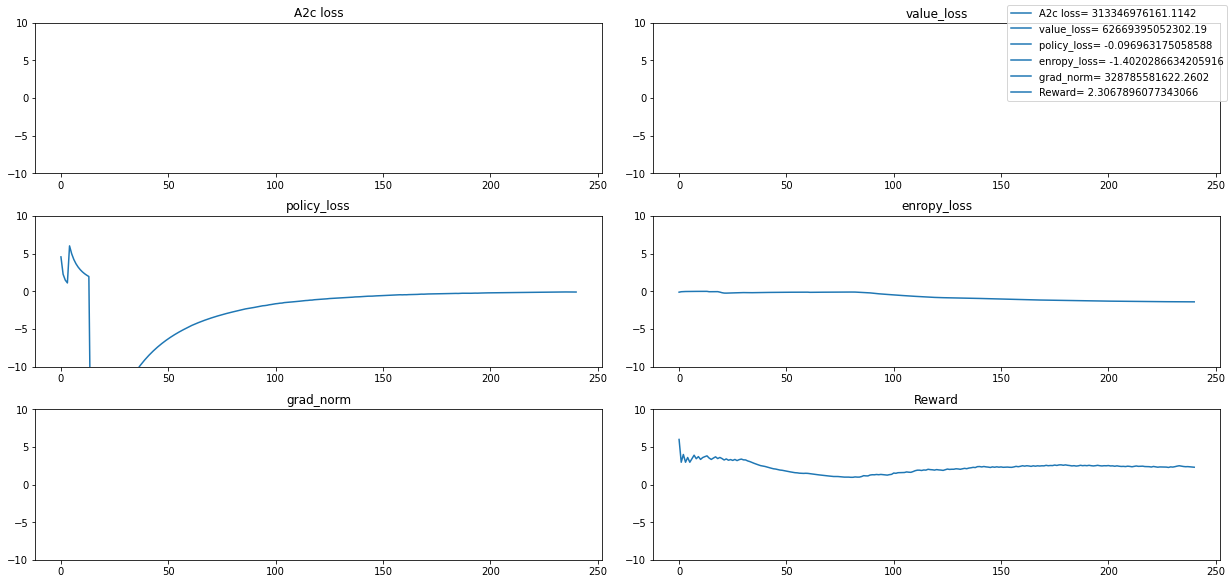

  0%|          | 252/100000 [10:36<66:38:29,  2.41s/it]

In [0]:
%%time
curves_names = ['A2c loss', 'value_loss', 'policy_loss', 'enropy_loss', 'grad_norm', 'Reward']
curves = [[], [], [], [], [], []]

for i in trange(LAST_EPOCH, TOTAL_EPOCH):
    trajectory = runner.get_next()
    losses = a2c.step(trajectory)
    
    for j, loss in enumerate(losses):
        curves[j].append(loss)
    curves[-1].append(play_and_evaluate(evaluate_env, model))
    
    if i and i % 20 == 0:
        clear_output(True)
        fig1, axs = plt.subplots(3, 2, figsize=FIG_SIZE, constrained_layout=True)
        for j, curve in enumerate(curves):
            axs[j // 2][j % 2].set_ylim((-10, 10))
            axs[j // 2][j % 2].set_title(curves_names[j])
            try:
                smoth_curve = moving_average(curve, span=100)
            except:
                print(f"Error with {curves_names[j]}")
                print(curve)
                continue
            axs[j // 2][j % 2].plot(smoth_curve, label=f'{curves_names[j]}= {smoth_curve[-1]}')
        fig1.legend()
        plt.show()
        